思路：
1，从股票回报率建立分布，构建分布函数，分布函数的自变量为standardized return
2，从MLE方法解出copula的参数
3，从copula产生随机分布样本u，v
4，由股票分布反解出return，并计算组合价值变化
5，重复上述过程，计算var

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.distributions.copula.api import GaussianCopula
from arch.univariate import arch_model

In [35]:
hsbc=pd.read_excel('Price History_20220502_1317.xlsx')
hangseng=pd.read_excel('Price History_20220502_1317 (1).xlsx')

we standardize the return of HSBC and hangseng bank.

In [36]:
hsbc_rtns=pd.DataFrame(hsbc['%Chg'].values,index=hsbc['Exchange Date'],columns=['pct_r'])
hs_rtns=pd.DataFrame(hangseng['%Chg'].values,index=hangseng['Exchange Date'],columns=['pct_r'])
hsbc_rtns.head()

,pct_r
Exchange Date,
03-Jan-2020,-0.0155
06-Jan-2020,-0.0034
07-Jan-2020,-0.0075
08-Jan-2020,-0.0023
09-Jan-2020,0.0065


In [12]:
garch=arch_model(hsbc_rtns*100,mean='ZERO',vol='GARCH',p=1,o=0,q=1,dist='Normal')
res=garch.fit()
hsgarch=arch_model(hs_rtns*100,mean='ZERO',vol='GARCH',p=1,o=0,q=1,dist='Normal')
hs_res=hsgarch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7392.750874981273
Iteration:      2,   Func. Count:     11,   Neg. LLF: 601.875728846076
Iteration:      3,   Func. Count:     17,   Neg. LLF: 594.4185824975639
Iteration:      4,   Func. Count:     22,   Neg. LLF: 591.7382708750426
Iteration:      5,   Func. Count:     27,   Neg. LLF: 592.39513741369
Iteration:      6,   Func. Count:     32,   Neg. LLF: 591.1036919132821
Iteration:      7,   Func. Count:     36,   Neg. LLF: 591.1023964142598
Iteration:      8,   Func. Count:     40,   Neg. LLF: 591.1023888712448
Iteration:      9,   Func. Count:     43,   Neg. LLF: 591.1023888712123
Optimization terminated successfully    (Exit mode 0)
            Current function value: 591.1023888712448
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 858.4757076232736
Iteration:      2,   Func. Count:     12,   Neg. LLF: 495.7947267518049
Iter

In [13]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -487.388
Distribution:                  Normal   AIC:                           980.776
Method:            Maximum Likelihood   BIC:                           991.304
                                        No. Observations:                  247
Date:                Tue, May 03 2022   Df Residuals:                      247
Time:                        16:55:26   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2939      0.160      1.838  6.611e-02 [-1.956e-02,  0.607]
alpha[1]       0.0993  3.975e-02      2.499  1.246e-02  [2.142e-02,  0.177]
beta[1]        0.8145  5.182e-02     15.716  1.183e-55    [  0.713,  0.916]
===========================================================================

Covariance estimator: robust
"""

In [14]:
hs_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -487.388
Distribution:                  Normal   AIC:                           980.776
Method:            Maximum Likelihood   BIC:                           991.304
                                        No. Observations:                  247
Date:                Tue, May 03 2022   Df Residuals:                      247
Time:                        16:55:26   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2939      0.160      1.838  6.611e-02 [-1.956e-02,  0.607]
alpha[1]       0.0993  3.975e-02      2.499  1.246e-02  [2.142e-02,  0.177]
beta[1]        0.8145  5.182e-02     15.716  1.183e-55    [  0.713,  0.916]
===========================================================================

Covariance estimator: robust
"""

so garch model for the return of HSBC is 
$\sigma_{t+1}^2=0.00004733+0.00001307 R_t^2 +0.00008108 \sigma_t^2 $

In [15]:
def garch(r,var):
    v=0.00004733+0.00001307*r+0.00008108*var
    return v

var=hsbc_rtns.iloc[0,0]**2
std_r=[]
for i in range(hsbc_rtns.shape[0]):
    std_r.append(hsbc_rtns.iloc[i,0]/np.sqrt(var))
    var=garch(hsbc_rtns.iloc[i,0],var)


In [49]:
hsbc_rtns['std_r']=std_r
hsbc_rtns.head()

,pct_r,std_r
Exchange Date,,
03-Jan-2020,-0.0155,-1.000000
06-Jan-2020,-0.0034,-0.495168
07-Jan-2020,-0.0075,-1.090635
08-Jan-2020,-0.0023,-0.334651
09-Jan-2020,0.0065,0.945073


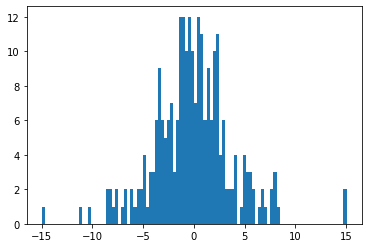

In [19]:
plt.hist(hsbc_rtns['std_r'],bins=100)
plt.show()

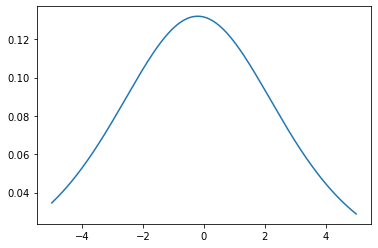

In [20]:
hsbc_df,hsbc_loc,hsbc_scl=t.fit(hsbc_rtns['std_r'])
x=np.linspace(-5,5,2000)
y=t.pdf(loc=hsbc_loc,scale=hsbc_scl,df=hsbc_df,x=x)
plt.plot(x,y)
plt.show()

$\sigma_{t+1}^2=0.00002939+0.00000993r_t^2+0.00008145\sigma_t^2$

In [39]:
def hs_garch(r,var):
    v=0.00002939+0.00000993*r+0.00008145*var
    return v
hs_var0=hs_rtns.iloc[0,0]**2
hs_std_r=[]
for i in range(hs_rtns.shape[0]):
    hs_std_r.append(hs_rtns.iloc[i,0]/np.sqrt(hs_var0))
    hs_var0=hs_garch(hs_rtns.iloc[i,0],hs_var0)
hs_rtns['hs_std_r']=hs_std_r
hs_rtns.head()

,pct_r,hs_std_r
Exchange Date,,
03-Jan-2020,-0.00253,-1.000000
06-Jan-2020,-0.00678,-1.251157
07-Jan-2020,0.00322,0.594616
08-Jan-2020,-0.00275,-0.506966
09-Jan-2020,0.01667,3.076238


In [40]:
hs_df,hs_loc,hs_scl=t.fit(hs_rtns['hs_std_r'])
print(hs_df,hs_loc,hs_scl)

3.4126762776173654 -0.15052424657506822 2.294028825151143


next we use MLE to estimate the gaussian copula model parameter $\rho$

In [56]:
# fill na value to the the length of dataframe equal
hs_rtns=pd.DataFrame(hs_rtns,index=hsbc_rtns.index)
hs_rtns.fillna(method='ffill',inplace=True)
hs_rtns_array=hs_rtns['hs_std_r'].values
hsbc_rtns_array=hsbc_rtns['std_r'].values
data=np.vstack((hs_rtns_array,hsbc_rtns_array))
data=data.T
copula=GaussianCopula(k_dim=2)
copula.fit_corr_param(data)

0.5005090615962972

so for the gaussian copula model, the paramater is 0.5

In [58]:
np.corrcoef(hs_rtns_array,hsbc_rtns_array)

array([[1.        , 0.52567692],
       [0.52567692, 1.        ]])

compared with correlation matrix, it is a little different. next we use the gaussian copula model to generate simulated data to calculate the var and es of portfolio value.

In [74]:
hsbc_predict=[]
hs_predict=[]
for i in range(20000):
    u1,u2=copula.rvs()
    hsbc_std_r1=t.ppf(u1,df=hsbc_df,loc=hsbc_loc,scale=hsbc_scl)
    hs_std_r1=t.ppf(u2,df=hs_df,loc=hs_loc,scale=hs_scl)
    hsbc_R=hsbc_std_r1*np.sqrt(var)
    hs_R=hs_std_r1*np.sqrt(hs_var0)
    hsbc_predict.append(hsbc_R)
    hs_predict.append(hs_R)


In [82]:
hsbc_predict.sort()
print(hsbc_predict[200])
hsbc_es=np.mean(hsbc_predict[:200])
print(hsbc_es)

-0.07028615859933518
-0.0951201650938394


In [83]:
hs_predict.sort()
print(hs_predict[200])
hs_es=np.mean(hs_predict[:200])
print(hs_es)

-0.05372610593240152
-0.07768510730711731
